# Zero-Shot Image-to-Text Generation for Visual-Semantic Arithmetic
A notebook to showcase the variety of scenarios presented in this [paper](https://arxiv.org/abs/2111.14447).  
Credits:  


```
@article{tewel2021zero,
  title={Zero-Shot Image-to-Text Generation for Visual-Semantic Arithmetic},
  author={Tewel, Yoad and Shalev, Yoav and Schwartz, Idan and Wolf, Lior},
  journal={arXiv preprint arXiv:2111.14447},
  year={2021}
}
```


While the code in this notebook can run on CPUs, it is preferable to run on a GPU runtime in order to speed up inference.

Install the missing requirements in the Colab runtime. Only *trasnformers* and *attrdict* missing.

In [1]:
!pip install transformers==4.11.2
!pip install attrdict

     |████████████████████████████████| 2.9 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 10.0 MB/s 
     |████████████████████████████████| 895 kB 41.2 MB/s 
     |████████████████████████████████| 61 kB 321 kB/s 
     |████████████████████████████████| 596 kB 37.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Install OpenAI's CLIP.

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-vb4f_mod
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-vb4f_mod
     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=476d99ee111ed3b75ff1496712ad29689c39c78d693938c88c6aa029cb66a2a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-fitowi53/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=cbb6cc2b2a95f9ee86043e186cade8c3341be14ed917158a8e4fbb3f02a7d923
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


Clone the paper's official GitHub repository.

In [3]:
!git clone https://github.com/YoadTew/zero-shot-image-to-text.git

Cloning into 'zero-shot-image-to-text'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (115/115), 1.69 MiB | 6.55 MiB/s, done.
Resolving deltas: 100% (45/45), done.


Add the *zero-shot-image-to-text* directory and sub-directories to the Python Path.

In [4]:
import sys
import os

sys.path.append('/content/zero-shot-image-to-text')
os.environ["PYTHONPATH"] += (":/content/zero-shot-image-to-text")

Defines a function that returns the caption that is most aligned with the input image features. The alignment score is based on the cosine distance between the text's and image's CLIP features.

In [5]:
import torch
import clip
from model.ZeroCLIP import CLIPTextGenerator
from IPython.display import Image, display

def calc_best_clip(text_generator, captions, image_features):
    encoded_captions = [text_generator.clip.encode_text(clip.tokenize(c).to(text_generator.device)) for c in captions]
    encoded_captions = [x / x.norm(dim=-1, keepdim=True) for x in encoded_captions]
    best_clip_idx = (torch.cat(encoded_captions) @ image_features.t()).squeeze().argmax().item()
    best_clip = captions[best_clip_idx]
    
    return best_clip

Define a function that returns the values of the hyper-parameters for a given scenario.

In [6]:
from attrdict import AttrDict
from enum import Enum

class GenType(Enum):
    Captioning = 0
    Arithmetic = 1
    RealWorld = 2
    OCR = 3
    
def get_args(gen_type):
    args = {}
    args['lm_model']="gpt-2"
    args['forbidden_tokens_file_path']='zero-shot-image-to-text/forbidden_tokens.npy'
    args['target_seq_length']=15
    args['reset_context_delta']=True
    args['num_iterations']=5
    args['clip_loss_temperature']=0.01
    args['clip_scale']=1
    args['ce_scale']=0.2
    args['stepsize']=0.3
    args['repetition_penalty']=1
    args['end_token']="."
    args['forbidden_factor']=20
    args['beam_size']=5

    if gen_type == GenType.Captioning:
        args['cond_text']="Image of a"
        args['end_factor']=1.01
        args['fusion_factor']=0.99
        args['grad_norm_factor']=0.9
    elif gen_type == GenType.Arithmetic:
        args['cond_text']="Image of a"
        args['end_factor']=1.06
        args['fusion_factor']=0.95
        args['grad_norm_factor']=0.95
    elif gen_type == GenType.RealWorld:
        args['cond_text']="Image of"
        args['end_factor']=1.04
        args['fusion_factor']=0.99
        args['grad_norm_factor']=0.9
    elif gen_type == GenType.OCR:
        args['cond_text']="Image of text that says"
        args['end_factor']=1.04
        args['fusion_factor']=0.99
        args['grad_norm_factor']=0.9
        
    return AttrDict(args)

Define a function to upload images to be used for the zero-shot imag-to-text tasks.

In [7]:
import os
import shutil
from google.colab import files

def upload_files(upload_path):
  uploaded = files.upload()
  for filename, content in uploaded.items():
    dst_path = os.path.join(upload_path, filename)
    shutil.move(filename, dst_path)
  return list(uploaded.keys())

#### Image Captioning

Upload an image.

In [26]:
!mkdir ./image_captioning_input
image_captioning_input_dir = 'image_captioning_input'

In [27]:
uploaded_files = upload_files(image_captioning_input_dir)

Saving a-room-at-the-beach.jpg to a-room-at-the-beach.jpg


Input image:


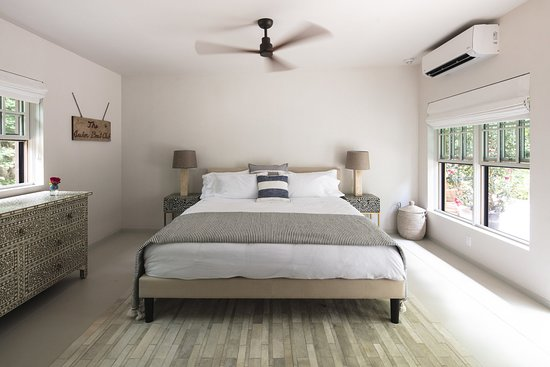

16/12/2021 10:50:38 | [' bedroom %% -1.0026944', ' bed %% -1.3492248', ' room %% -3.6324854', ' kitchen %% -4.0306144', ' bathroom %% -4.0871596']
16/12/2021 10:53:11 | [' bedroom with %% -2.967814', ' bed. %% -3.0338945', ' bedroom. %% -3.1080732', ' bedroom in %% -3.123005', ' bed in %% -3.133387']


/content/zero-shot-image-to-text/model/ZeroCLIP.py:177: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_tokens_source = next_tokens // scores_sum.shape[1]


16/12/2021 10:55:44 | [' bed.! %% -3.0338945', ' bedroom with o %% -3.057289', ' bedroom.! %% -3.1080732', ' bedroom with with %% -3.325843', ' bedroom with on %% -3.4198182']
16/12/2021 10:58:17 | [' bed.!! %% -3.0338945', ' bedroom.!! %% -3.1080732', ' bedroom with with fan %% -3.578238', ' bedroom with ott %% -3.6478186', ' bedroom with with fans %% -3.6721745']
16/12/2021 11:00:49 | [' bed.!!! %% -3.0338945', ' bedroom.!!! %% -3.1080732', ' bedroom with ottom %% -3.7014694', ' bedroom with ottoman %% -3.7727172', ' bedroom with with fans blowing %% -3.8072789']
16/12/2021 11:03:22 | [' bed.!!!! %% -3.0338945', ' bedroom.!!!! %% -3.1080732', ' bedroom with ottom socks %% -3.6555746', ' bedroom with ottom clothes %% -3.9815485', ' bedroom with ottom sleep %% -4.0270085']
16/12/2021 11:05:55 | [' bed.!!!!! %% -3.0338945', ' bedroom.!!!!! %% -3.1080732', ' bedroom with ottom socks on %% -3.8816261', ' bedroom with ottom socks. %% -3.9089', ' bedroom with ottom socks in %% -3.9100869']


In [28]:
img_path = os.path.join(image_captioning_input_dir, uploaded_files[0])

print('Input image:')
display(Image(img_path, width = 300, height = 300))

captioning_args = get_args(GenType.Captioning)

text_generator = CLIPTextGenerator(**dict(captioning_args))
image_features = text_generator.get_img_feature([img_path], None)
captions = text_generator.run(image_features, captioning_args.cond_text, beam_size=captioning_args.beam_size)

best_clip = calc_best_clip(text_generator, captions, image_features)

print('all captions:', captions)
print('best clip:', captioning_args.cond_text + best_clip)

#### Arithmetic with images.

Upload images.

In [29]:
!mkdir ./arithmetic_input
arithmetic_input_dir = 'arithmetic_input'

In [33]:
uploaded_files = upload_files(arithmetic_input_dir)

Saving image-a.jpg to image-a.jpg
Saving image-b.jpg to image-b.jpg
Saving image-c.jpg to image-c.jpg


Input images:


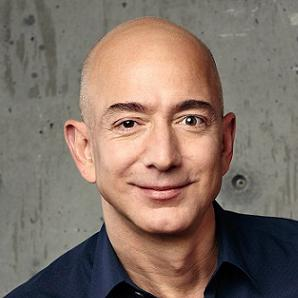

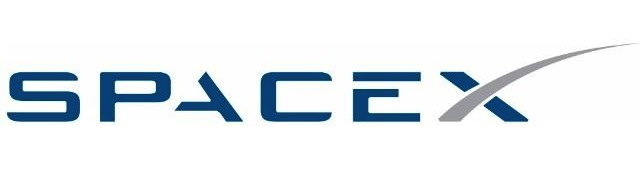

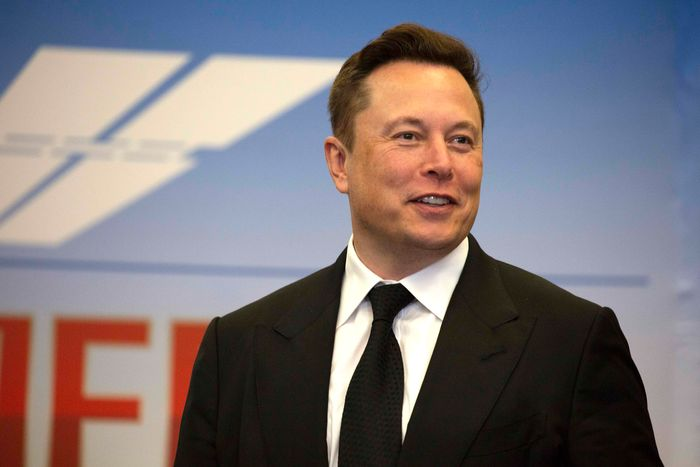

16/12/2021 11:17:40 | [' company %% -1.8104516', ' new %% -3.0129488', ' brand %% -3.2549577', ' game %% -3.5608108', ' product %% -4.215863']
16/12/2021 11:20:13 | [' company. %% -1.9517682', ' brand. %% -2.5449014', ' game. %% -2.904492', ' new Amazon %% -3.0474274', ' product. %% -3.533887']


/content/zero-shot-image-to-text/model/ZeroCLIP.py:177: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_tokens_source = next_tokens // scores_sum.shape[1]


16/12/2021 11:22:45 | [' company.! %% -1.9517682', ' brand.! %% -2.5449014', ' new Amazon. %% -2.7118556', ' game.! %% -2.904492', ' new Amazon logo %% -3.5109594']
16/12/2021 11:25:18 | [' company.!! %% -1.9517682', ' brand.!! %% -2.5449014', ' new Amazon.! %% -2.7118556', ' game.!! %% -2.904492', ' new Amazon logo. %% -3.046876']
all captions: [' company.', ' brand.', ' new Amazon.', ' game.', ' new Amazon logo.']
best clip: Image of a new Amazon logo.


In [36]:
arithmetics_imgs = [os.path.join(arithmetic_input_dir, uploaded_files[0]),
                    os.path.join(arithmetic_input_dir, uploaded_files[1]),
                    os.path.join(arithmetic_input_dir, uploaded_files[2])
]
arithmetics_weights=[1, 1, -1]
arithmetics_args = get_args(GenType.Arithmetic)

text_generator = CLIPTextGenerator(**dict(arithmetics_args))

print("Input images:")
for i, img_path in enumerate(arithmetics_imgs):
    display(Image(img_path, width = 100, height = 100))

image_features = text_generator.get_combined_feature(arithmetics_imgs, [], arithmetics_weights, None)
captions = text_generator.run(image_features, arithmetics_args.cond_text, beam_size=arithmetics_args.beam_size)

best_clip = calc_best_clip(text_generator, captions, image_features)

print('all captions:', captions)
print('best clip:', arithmetics_args.cond_text + best_clip)

#### Real-world knowledge.

Upload an image.

In [8]:
!mkdir ./real_world_knowledge_input
real_world_knowledge_input_dir = 'real_world_knowledge_input'

In [10]:
uploaded_files = upload_files(real_world_knowledge_input_dir)

Saving 49.jpg to 49.jpg


In [18]:
img_path

'./zero-shot-image-to-text/real_world_knowledge_input/49.jpg'

Input image:


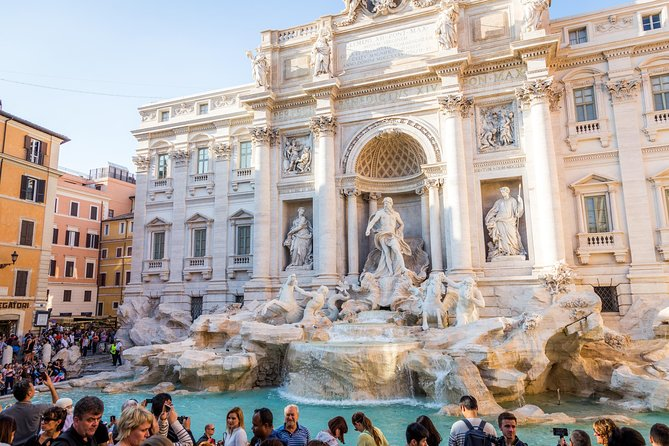

16/12/2021 10:15:44 | [' the %% -1.9319073', ' Rome %% -4.283534', ' The %% -4.4921865', ' London %% -4.707574', ' Italy %% -4.8670964']
16/12/2021 10:18:16 | [' the Vatican %% -3.6207027', ' the Roman %% -3.6930969', ' the city %% -3.8824542', ' Rome. %% -3.9148688', ' the Italian %% -3.9394743']


/content/zero-shot-image-to-text/model/ZeroCLIP.py:177: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_tokens_source = next_tokens // scores_sum.shape[1]


16/12/2021 10:20:49 | [' the city. %% -3.4397123', ' the Vatican. %% -3.6250887', ' the Vatican swimming %% -3.812372', ' the Vatican Pool %% -3.8184128', ' Rome.! %% -3.9148688']
16/12/2021 10:23:22 | [' the city.! %% -3.4397123', ' the Vatican.! %% -3.6250887', ' the Vatican Pool. %% -3.718681', ' the Vatican swimming pool %% -3.7680612', ' Rome.!! %% -3.9148688']
16/12/2021 10:25:55 | [' the city.!! %% -3.4397123', ' the Vatican swimming pool. %% -3.6134048', ' the Vatican.!! %% -3.6250887', ' the Vatican Pool.! %% -3.718681', ' Rome.!!! %% -3.9148688']
all captions: [' the city.', ' the Vatican swimming pool.', ' the Vatican.', ' the Vatican Pool.', ' Rome.']
best clip: Image of Rome.


In [19]:
img_path = os.path.join(real_world_knowledge_input_dir, uploaded_files[0])
rw_args = get_args(GenType.RealWorld)

text_generator = CLIPTextGenerator(**dict(rw_args))

print('Input image:')
display(Image(img_path, width = 300, height = 300))

image_features = text_generator.get_img_feature([img_path], None)
captions = text_generator.run(image_features, rw_args.cond_text, beam_size=rw_args.beam_size)

best_clip = calc_best_clip(text_generator, captions, image_features)

print('all captions:', captions)
print('best clip:', rw_args.cond_text + best_clip)

#### OCR

Upload an image.

In [20]:
!mkdir ./ocr_input
ocr_input_dir = 'ocr_input'

In [24]:
uploaded_files = upload_files(ocr_input_dir)

Saving images.png to images.png


Input image:


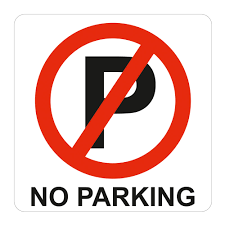

16/12/2021 10:38:48 | [' " %% -2.6474085', ' no %% -3.9611971', " ' %% -4.0666595", ' NO %% -4.2389107', ' No %% -4.6661644']
16/12/2021 10:41:20 | [' no. %% -3.012267', ' NO parking %% -3.5755994', ' "no %% -3.6807854', ' "No %% -3.7403066', ' "not %% -3.7516491']


/content/zero-shot-image-to-text/model/ZeroCLIP.py:177: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_tokens_source = next_tokens // scores_sum.shape[1]


16/12/2021 10:43:53 | [' no.! %% -3.012267', ' NO parking. %% -3.2242963', ' "No Parking %% -3.2846909', ' "no parking %% -3.3055089', ' "No parking %% -3.5721314']
16/12/2021 10:46:26 | [' no.!! %% -3.012267', ' NO parking.! %% -3.2242963', ' "no parking. %% -3.3383088', ' "No Parking. %% -3.3978772', ' "No parking. %% -3.447359']
all captions: [' no.', ' NO parking.', ' "no parking.', ' "No Parking.', ' "No parking.']
best clip: Image of text that says "no parking.


In [25]:
img_path = os.path.join(ocr_input_dir, uploaded_files[0])
ocr_args = get_args(GenType.OCR)

text_generator = CLIPTextGenerator(**dict(ocr_args))

print('Input image:')
display(Image(img_path, width = 300, height = 300))

image_features = text_generator.get_img_feature([img_path], None)
captions = text_generator.run(image_features, ocr_args.cond_text, beam_size=ocr_args.beam_size)

best_clip = calc_best_clip(text_generator, captions, image_features)

print('all captions:', captions)
print('best clip:', ocr_args.cond_text + best_clip)